# Modelos de Linguagem com LSTM

Este notebook introduz os **Modelos de Linguagem** (*Language Models*), uma das aplicações mais fundamentais e poderosas do processamento de linguagem natural. Exploraremos a teoria matemática por trás desses modelos e implementaremos uma versão prática usando **Long Short-Term Memory (LSTM)** networks com PyTorch.

## Conteúdos Abordados

1. **Fundamentos Teóricos de Modelos de Linguagem**: A matemática da modelagem probabilística da linguagem
2. **Long Short-Term Memory (LSTM)**: Arquitetura avançada para sequências longas
3. **Implementação de um Modelo de Linguagem com LSTM**: Construção completa do pipeline
4. **Geração Autorregressiva**: Como gerar texto de forma probabilística
5. **Análise de Perplexidade**: Métrica de avaliação de modelos de linguagem
6. **Análise dos Embeddings Aprendidos**: Visualização do espaço semântico

## 1. Fundamentos Teóricos de Modelos de Linguagem

Um **modelo de linguagem** é um modelo probabilístico que atribui probabilidades a sequências de palavras. Formalmente, dado um vocabulário $V$ e uma sequência de palavras $w_1, w_2, \ldots, w_T$, um modelo de linguagem estima a probabilidade conjunta:

$$P(w_1, w_2, \ldots, w_T)$$

### Decomposição Autorregressiva

Pela regra da cadeia da probabilidade, podemos decompor essa probabilidade conjunta como:

$$P(w_1, w_2, \ldots, w_T) = \prod_{t=1}^{T} P(w_t | w_1, w_2, \ldots, w_{t-1})$$

Onde $P(w_t | w_1, \ldots, w_{t-1})$ é a **probabilidade condicional** da palavra $w_t$ dado todo o contexto anterior. Esta decomposição é chamada de **autorregressiva** porque cada palavra é modelada condicionalmente em relação às palavras anteriores.

### O Problema da Maldição da Dimensionalidade

Estimar $P(w_t | w_1, \ldots, w_{t-1})$ diretamente é impraticável, pois:
1. O número de possíveis contextos cresce exponencialmente com o comprimento
2. A maioria das sequências específicas nunca aparece nos dados de treino

### Aproximação Neural

Modelos neurais de linguagem resolvem este problema aprendendo uma função paramétrica $f_\theta$:

$$P(w_t | w_1, \ldots, w_{t-1}) \approx f_\theta(w_1, \ldots, w_{t-1})$$

Onde $\theta$ representa os parâmetros da rede neural (pesos e biases).

## 2. Long Short-Term Memory (LSTM)

Enquanto RNNs tradicionais sofrem do problema de **desvanecimento do gradiente** (*vanishing gradient*), as **LSTMs** foram projetadas especificamente para capturar dependências de longo prazo em sequências.

### Arquitetura da Célula LSTM

Uma célula LSTM possui três **gates** (portões) que controlam o fluxo de informação:

1. **Forget Gate** ($f_t$): Decide quanta informação descartar do estado da célula
2. **Input Gate** ($i_t$): Decide quais valores atualizar no estado da célula
3. **Output Gate** ($o_t$): Controla quais partes do estado da célula serão outputadas

### Equações Matemáticas da LSTM

Para o tempo $t$, com entrada $x_t$ e estado oculto anterior $h_{t-1}$:

**Gates:**
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$

**Candidato a novo estado:**
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

**Estado da célula:**
$$C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$$

**Estado oculto:**
$$h_t = o_t * \tanh(C_t)$$

Onde $\sigma$ é a função sigmoid, $*$ denota multiplicação elemento-a-elemento, e $W$, $b$ são as matrizes de pesos e vetores de bias, respectivamente.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
from collections import Counter
import math

## 3. Preparação dos Dados

Para treinar nosso modelo de linguagem, utilizaremos um corpus de texto em português. O processo de preparação envolve:

1. **Limpeza e tokenização** do texto
2. **Construção do vocabulário** com as palavras mais frequentes
3. **Criação de sequências** de treinamento com janela deslizante
4. **Mapeamento** de tokens para índices numéricos

In [5]:
# Corpus expandido em português sobre inteligência artificial
corpus_text = """
A inteligencia artificial e uma area da ciencia da computacao que se concentra no desenvolvimento de sistemas capazes de realizar tarefas que normalmente requerem inteligencia humana.
O aprendizado de maquina e um subcampo da inteligencia artificial que permite aos computadores aprender e melhorar automaticamente atraves da experiencia.
As redes neurais artificiais sao inspiradas no funcionamento do cerebro humano e consistem em nos interconectados que processam informacoes.
O aprendizado profundo utiliza redes neurais com multiplas camadas para modelar e compreender dados complexos.
Os algoritmos de aprendizado supervisionado aprendem a partir de exemplos rotulados para fazer predicoes sobre novos dados.
O aprendizado nao supervisionado descobre padroes ocultos em dados sem rotulos explicitos.
O processamento de linguagem natural permite que os computadores compreendam e gerem texto em linguagem humana.
A visao computacional capacita as maquinas a interpretar e analisar conteudo visual do mundo real.
Os sistemas de recomendacao utilizam algoritmos de aprendizado de maquina para sugerir produtos ou conteudo aos usuarios.
A robotica integra inteligencia artificial com engenharia mecanica para criar maquinas autonomas.
O reconhecimento de padroes e fundamental para identificar estruturas e regularidades nos dados.
Os modelos generativos podem criar novos dados que se assemelham aos dados de treinamento originais.
A otimizacao e crucial para encontrar os melhores parametros em algoritmos de aprendizado de maquina.
O overfitting ocorre quando um modelo aprende muito especificamente os dados de treino perdendo capacidade de generalizacao.
A validacao cruzada e uma tecnica para avaliar o desempenho de modelos de forma mais robusta.
As funcoes de ativacao introduzem nao linearidade nas redes neurais permitindo modelar relacoes complexas.
O gradiente descendente e um algoritmo de otimizacao usado para treinar modelos de aprendizado de maquina.
A regularizacao ajuda a prevenir o overfitting adicionando penalidades aos parametros do modelo.
Os transformadores revolucionaram o processamento de linguagem natural com mecanismos de atencao.
A inteligencia artificial generativa pode criar texto imagens audio e outros tipos de conteudo criativo.
"""

print(f"Tamanho do corpus: {len(corpus_text)} caracteres")
print(f"Primeiros 200 caracteres:")
print(corpus_text[:200])

Tamanho do corpus: 2271 caracteres
Primeiros 200 caracteres:

A inteligencia artificial e uma area da ciencia da computacao que se concentra no desenvolvimento de sistemas capazes de realizar tarefas que normalmente requerem inteligencia humana.
O aprendizado d


In [6]:
def preprocess_text(text):
    """Limpa e tokeniza o texto."""
    # Converter para minúsculas e remover caracteres especiais
    text = text.lower()
    text = re.sub(r'[^a-záàâãéèêíìîóòôõúùûç\s]', '', text)

    # Tokenizar por palavras
    tokens = text.split()

    return tokens

def build_vocabulary(tokens, vocab_size=1000):
    """Constrói vocabulário com as palavras mais frequentes."""
    counter = Counter(tokens)

    # Tokens especiais
    special_tokens = ['<UNK>', '<START>', '<END>']

    # Palavras mais frequentes (excluindo tokens especiais)
    frequent_words = [word for word, _ in counter.most_common(vocab_size - len(special_tokens))]

    # Vocabulário completo
    vocabulary = special_tokens + frequent_words

    # Mapeamentos
    word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    return vocabulary, word_to_idx, idx_to_word

# Processar o corpus
tokens = preprocess_text(corpus_text)
vocabulary, word_to_idx, idx_to_word = build_vocabulary(tokens, vocab_size=200)

print(f"Total de tokens: {len(tokens)}")
print(f"Vocabulário único: {len(vocabulary)}")
print(f"Primeiras 20 palavras do vocabulário: {vocabulary[:20]}")

Total de tokens: 316
Vocabulário único: 174
Primeiras 20 palavras do vocabulário: ['<UNK>', '<START>', '<END>', 'de', 'e', 'a', 'o', 'para', 'aprendizado', 'dados', 'os', 'que', 'inteligencia', 'artificial', 'da', 'maquina', 'aos', 'em', 'um', 'as']


In [7]:
def encode_tokens(tokens, word_to_idx):
    """Converte tokens em índices numéricos."""
    unk_idx = word_to_idx['<UNK>']
    return [word_to_idx.get(token, unk_idx) for token in tokens]

def create_training_sequences(encoded_tokens, seq_length):
    """Cria sequências de entrada e alvos para treinamento."""
    sequences = []
    targets = []

    for i in range(len(encoded_tokens) - seq_length):
        seq = encoded_tokens[i:i + seq_length]
        target = encoded_tokens[i + seq_length]
        sequences.append(seq)
        targets.append(target)

    return sequences, targets

# Codificar tokens
encoded_tokens = encode_tokens(tokens, word_to_idx)

# Criar sequências de treinamento
seq_length = 10  # Comprimento da sequência de contexto
sequences, targets = create_training_sequences(encoded_tokens, seq_length)

print(f"Número total de sequências de treinamento: {len(sequences)}")
print(f"Exemplo de sequência: {sequences[0]}")
print(f"Alvo correspondente: {targets[0]}")

# Decodificar para verificar
example_seq_words = [idx_to_word[idx] for idx in sequences[0]]
example_target_word = idx_to_word[targets[0]]
print(f"Sequência em palavras: {example_seq_words}")
print(f"Alvo em palavra: {example_target_word}")

Número total de sequências de treinamento: 306
Exemplo de sequência: [5, 12, 13, 4, 29, 50, 14, 51, 14, 52]
Alvo correspondente: 11
Sequência em palavras: ['a', 'inteligencia', 'artificial', 'e', 'uma', 'area', 'da', 'ciencia', 'da', 'computacao']
Alvo em palavra: que


## 4. Dataset Personalizado para PyTorch

Criaremos uma classe Dataset personalizada para facilitar o carregamento dos dados em lotes (*batches*) durante o treinamento.

In [8]:
class LanguageModelDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.LongTensor(self.sequences[idx]),
            torch.LongTensor([self.targets[idx]])
        )

# Criar dataset e dataloader
dataset = LanguageModelDataset(sequences, targets)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset criado com {len(dataset)} exemplos")
print(f"Número de lotes: {len(dataloader)}")

# Testar um lote
for batch_seq, batch_target in dataloader:
    print(f"Formato do lote de sequências: {batch_seq.shape}")
    print(f"Formato do lote de alvos: {batch_target.shape}")
    break

Dataset criado com 306 exemplos
Número de lotes: 10
Formato do lote de sequências: torch.Size([32, 10])
Formato do lote de alvos: torch.Size([32, 1])


## 5. Implementação do Modelo de Linguagem com LSTM

Nossa arquitetura consistirá em:

1. **Camada de Embedding**: Converte índices de palavras em vetores densos
2. **Camada LSTM**: Processa a sequência e mantém memória de longo prazo
3. **Camada Linear de Saída**: Projeta do espaço oculto para o vocabulário
4. **Dropout**: Regularização para prevenir overfitting

A saída final são **logits** sobre todo o vocabulário, que são convertidos em probabilidades via **softmax**.

In [9]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.3):
        super(LSTMLanguageModel, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.vocab_size = vocab_size

        # Camadas da rede
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        """
        Forward pass do modelo.

        Args:
            x: tensor de entrada [batch_size, seq_length]
            hidden: estado oculto inicial (opcional)

        Returns:
            output: logits sobre vocabulário [batch_size, seq_length, vocab_size]
            hidden: estado oculto final
        """
        batch_size = x.size(0)

        # Embedding: [batch_size, seq_length] -> [batch_size, seq_length, embedding_dim]
        embedded = self.embedding(x)

        # LSTM: [batch_size, seq_length, embedding_dim] -> [batch_size, seq_length, hidden_dim]
        lstm_out, hidden = self.lstm(embedded, hidden)

        # Dropout para regularização
        lstm_out = self.dropout(lstm_out)

        # Projeção para vocabulário: [batch_size, seq_length, hidden_dim] -> [batch_size, seq_length, vocab_size]
        output = self.fc_out(lstm_out)

        return output, hidden

    def init_hidden(self, batch_size, device):
        """Inicializa estado oculto com zeros."""
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))

# Hiperparâmetros do modelo
vocab_size = len(vocabulary)
embedding_dim = 64
hidden_dim = 128
num_layers = 2
dropout = 0.3

# Instanciar modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMLanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)
model = model.to(device)

print(f"Modelo criado com {sum(p.numel() for p in model.parameters())} parâmetros")
print(f"Dispositivo: {device}")
print(model)

Modelo criado com 265006 parâmetros
Dispositivo: cpu
LSTMLanguageModel(
  (embedding): Embedding(174, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=128, out_features=174, bias=True)
)


## 6. Treinamento do Modelo

O treinamento de um modelo de linguagem usa **Cross-Entropy Loss** entre as probabilidades preditas e as palavras reais. A cada época, passamos todas as sequências pelo modelo e atualizamos os parâmetros via **backpropagation**.

### Função de Loss

Para uma sequência de entrada $x_1, \ldots, x_T$ e alvo $y$, a loss é:

$$\mathcal{L} = -\log P(y | x_1, \ldots, x_T) = -\log \frac{\exp(\text{logit}_y)}{\sum_{i=1}^{|V|} \exp(\text{logit}_i)}$$

In [10]:
# Configuração de treinamento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

# Lista para armazenar perdas
training_losses = []

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Treina o modelo por uma época."""
    model.train()
    total_loss = 0.0
    num_batches = 0

    for batch_seq, batch_target in dataloader:
        batch_seq = batch_seq.to(device)
        batch_target = batch_target.squeeze(-1).to(device)  # Remove dimensão extra

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output, _ = model(batch_seq)

        # Pegar apenas o último token de saída para cada sequência
        # output shape: [batch_size, seq_length, vocab_size]
        # Queremos: [batch_size, vocab_size]
        last_output = output[:, -1, :]

        # Calcular loss
        loss = criterion(last_output, batch_target)

        # Backward pass
        loss.backward()

        # Gradient clipping (importante para LSTMs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Atualizar parâmetros
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

print("Iniciando treinamento...")

for epoch in tqdm(range(num_epochs)):
    epoch_loss = train_epoch(model, dataloader, criterion, optimizer, device)
    training_losses.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Treinamento concluído!")

Iniciando treinamento...


  0%|          | 0/50 [00:00<?, ?it/s]

Época [10/50], Loss: 4.0367
Época [20/50], Loss: 2.4404
Época [30/50], Loss: 1.5880
Época [40/50], Loss: 0.9793
Época [50/50], Loss: 0.6136
Treinamento concluído!


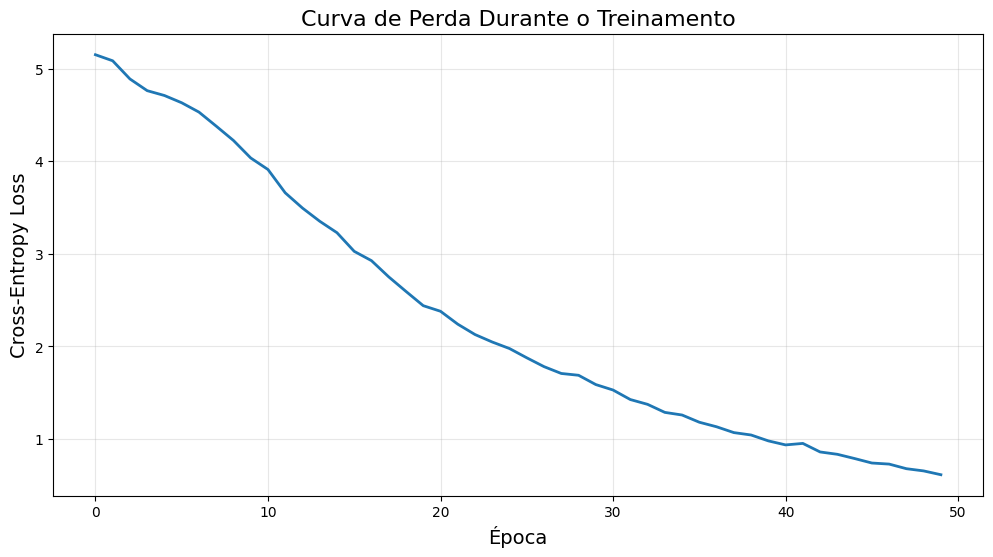

Perda inicial: 5.1525
Perda final: 0.6136
Redução: 88.1%


In [11]:
# Visualizar curva de perda
plt.figure(figsize=(12, 6))
plt.plot(training_losses, linewidth=2)
plt.title('Curva de Perda Durante o Treinamento', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('Cross-Entropy Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Perda inicial: {training_losses[0]:.4f}")
print(f"Perda final: {training_losses[-1]:.4f}")
print(f"Redução: {((training_losses[0] - training_losses[-1]) / training_losses[0] * 100):.1f}%")

## 7. Geração Autorregressiva de Texto

Agora implementaremos a **geração autorregressiva**, onde o modelo gera texto palavra por palavra, usando suas próprias predições anteriores como entrada para as próximas predições.

### Processo de Geração

1. Começamos com uma sequência *seed* (semente)
2. O modelo prediz a próxima palavra mais provável
3. Adicionamos essa palavra à sequência
4. Repetimos o processo usando a nova sequência como entrada

### Estratégias de Amostragem

- **Greedy**: Sempre escolher a palavra mais provável
- **Random Sampling**: Amostrar aleatoriamente da distribuição de probabilidade
- **Temperature Sampling**: Controlar a "criatividade" com um parâmetro de temperatura

In [12]:
def generate_text(model, seed_text, max_length=50, temperature=1.0, device='cpu'):
    """
    Gera texto usando o modelo treinado.

    Args:
        model: modelo LSTM treinado
        seed_text: texto inicial (string)
        max_length: número máximo de palavras a gerar
        temperature: controla aleatoriedade (1.0 = normal, >1.0 = mais criativo, <1.0 = mais conservador)
        device: dispositivo (cpu ou cuda)

    Returns:
        texto gerado (string)
    """
    model.eval()

    # Tokenizar e codificar texto seed
    seed_tokens = preprocess_text(seed_text)
    if len(seed_tokens) == 0:
        seed_tokens = ['inteligencia']  # Fallback

    # Codificar tokens
    seed_indices = encode_tokens(seed_tokens, word_to_idx)

    # Garantir que temos pelo menos seq_length tokens
    if len(seed_indices) < seq_length:
        # Pad com tokens <START>
        start_idx = word_to_idx['<START>']
        seed_indices = [start_idx] * (seq_length - len(seed_indices)) + seed_indices
    else:
        # Usar apenas os últimos seq_length tokens
        seed_indices = seed_indices[-seq_length:]

    generated_indices = seed_indices.copy()
    current_sequence = seed_indices.copy()

    with torch.no_grad():
        for _ in range(max_length):
            # Converter para tensor
            input_tensor = torch.LongTensor([current_sequence]).to(device)

            # Forward pass
            output, _ = model(input_tensor)

            # Pegar logits da última posição
            last_logits = output[0, -1, :]

            # Aplicar temperature
            if temperature != 1.0:
                last_logits = last_logits / temperature

            # Converter para probabilidades
            probabilities = F.softmax(last_logits, dim=0)

            # Amostrar próxima palavra
            if temperature == 0.0:  # Greedy
                next_token_idx = torch.argmax(probabilities).item()
            else:  # Sampling
                next_token_idx = torch.multinomial(probabilities, 1).item()

            # Parar se gerar token de fim
            if next_token_idx == word_to_idx.get('<END>', -1):
                break

            # Adicionar nova palavra
            generated_indices.append(next_token_idx)

            # Atualizar sequência atual (janela deslizante)
            current_sequence = current_sequence[1:] + [next_token_idx]

    # Decodificar de volta para texto
    generated_words = []
    for idx in generated_indices:
        word = idx_to_word.get(idx, '<UNK>')
        if word not in ['<START>', '<END>', '<UNK>']:
            generated_words.append(word)

    return ' '.join(generated_words)

# Testar geração com diferentes seeds e temperaturas
seeds = [
    "inteligencia artificial",
    "aprendizado de maquina",
    "redes neurais"
]

temperatures = [0.5, 1.0, 1.5]

print("=== EXEMPLOS DE GERAÇÃO DE TEXTO ===")
print()

for seed in seeds:
    print(f"Seed: '{seed}'")
    print("-" * 50)

    for temp in temperatures:
        generated_text = generate_text(model, seed, max_length=30, temperature=temp, device=device)
        print(f"Temperature {temp}: {generated_text}")

    print()


=== EXEMPLOS DE GERAÇÃO DE TEXTO ===

Seed: 'inteligencia artificial'
--------------------------------------------------
Temperature 0.5: inteligencia artificial o o para para para para e dados de de aprendizado aprendizado aprendizado nao nao a a e overfitting um em aos dados criar os os de de de maquina
Temperature 1.0: inteligencia artificial adicionando que com o para e redes os novos dados de de de maquina supervisionado maquina modelo um ou rotulos complexas natural robotica a com com computadores artificial artificial para
Temperature 1.5: inteligencia artificial inteligencia generativa otimizacao a para e imagens tipos outros em de fundamental compreendam sugerir ajuda visao um aos nos parametros modelo autonomas o introduzem fundamental natural maquina de fundamental otimizacao

Seed: 'aprendizado de maquina'
--------------------------------------------------
Temperature 0.5: aprendizado de maquina inteligencia descobre o ocorre ocorre para muito aprende muito os de de de de a

## 8. Avaliação: Perplexidade do Modelo

A **perplexidade** é a métrica padrão para avaliar modelos de linguagem. Ela mede quão "surpreso" o modelo fica com uma sequência de palavras. Matematicamente:

$$\text{Perplexidade} = \exp\left(-\frac{1}{T} \sum_{t=1}^{T} \log P(w_t | w_1, \ldots, w_{t-1})\right)$$

- **Perplexidade menor** = modelo melhor
- **Perplexidade = tamanho do vocabulário** = modelo aleatório
- **Perplexidade = 1** = modelo perfeito (impossível na prática)

In [13]:
def calculate_perplexity(model, dataloader, device):
    """
    Calcula perplexidade do modelo nos dados de teste.
    """
    model.eval()
    total_loss = 0.0
    num_tokens = 0

    criterion = nn.CrossEntropyLoss(reduction='sum')

    with torch.no_grad():
        for batch_seq, batch_target in dataloader:
            batch_seq = batch_seq.to(device)
            batch_target = batch_target.squeeze(-1).to(device)

            # Forward pass
            output, _ = model(batch_seq)

            # Última saída de cada sequência
            last_output = output[:, -1, :]

            # Calcular loss
            loss = criterion(last_output, batch_target)

            total_loss += loss.item()
            num_tokens += batch_target.size(0)

    # Perplexidade é exp da loss média
    average_loss = total_loss / num_tokens
    perplexity = math.exp(average_loss)

    return perplexity, average_loss

# Calcular perplexidade no conjunto de dados
perplexity, average_loss = calculate_perplexity(model, dataloader, device)

print(f"=== AVALIAÇÃO DO MODELO ===")
print(f"Perda média: {average_loss:.4f}")
print(f"Perplexidade: {perplexity:.2f}")
print(f"Tamanho do vocabulário: {vocab_size}")
print(f"Perplexidade de modelo aleatório: {vocab_size}")
print(f"Melhoria sobre modelo aleatório: {(vocab_size - perplexity):.2f} pontos")

=== AVALIAÇÃO DO MODELO ===
Perda média: 0.4313
Perplexidade: 1.54
Tamanho do vocabulário: 174
Perplexidade de modelo aleatório: 174
Melhoria sobre modelo aleatório: 172.46 pontos


## 9. Análise dos Embeddings Aprendidos

Vamos visualizar os embeddings de palavras que o modelo aprendeu durante o treinamento. Palavras semanticamente similares devem ter embeddings próximos no espaço vetorial.

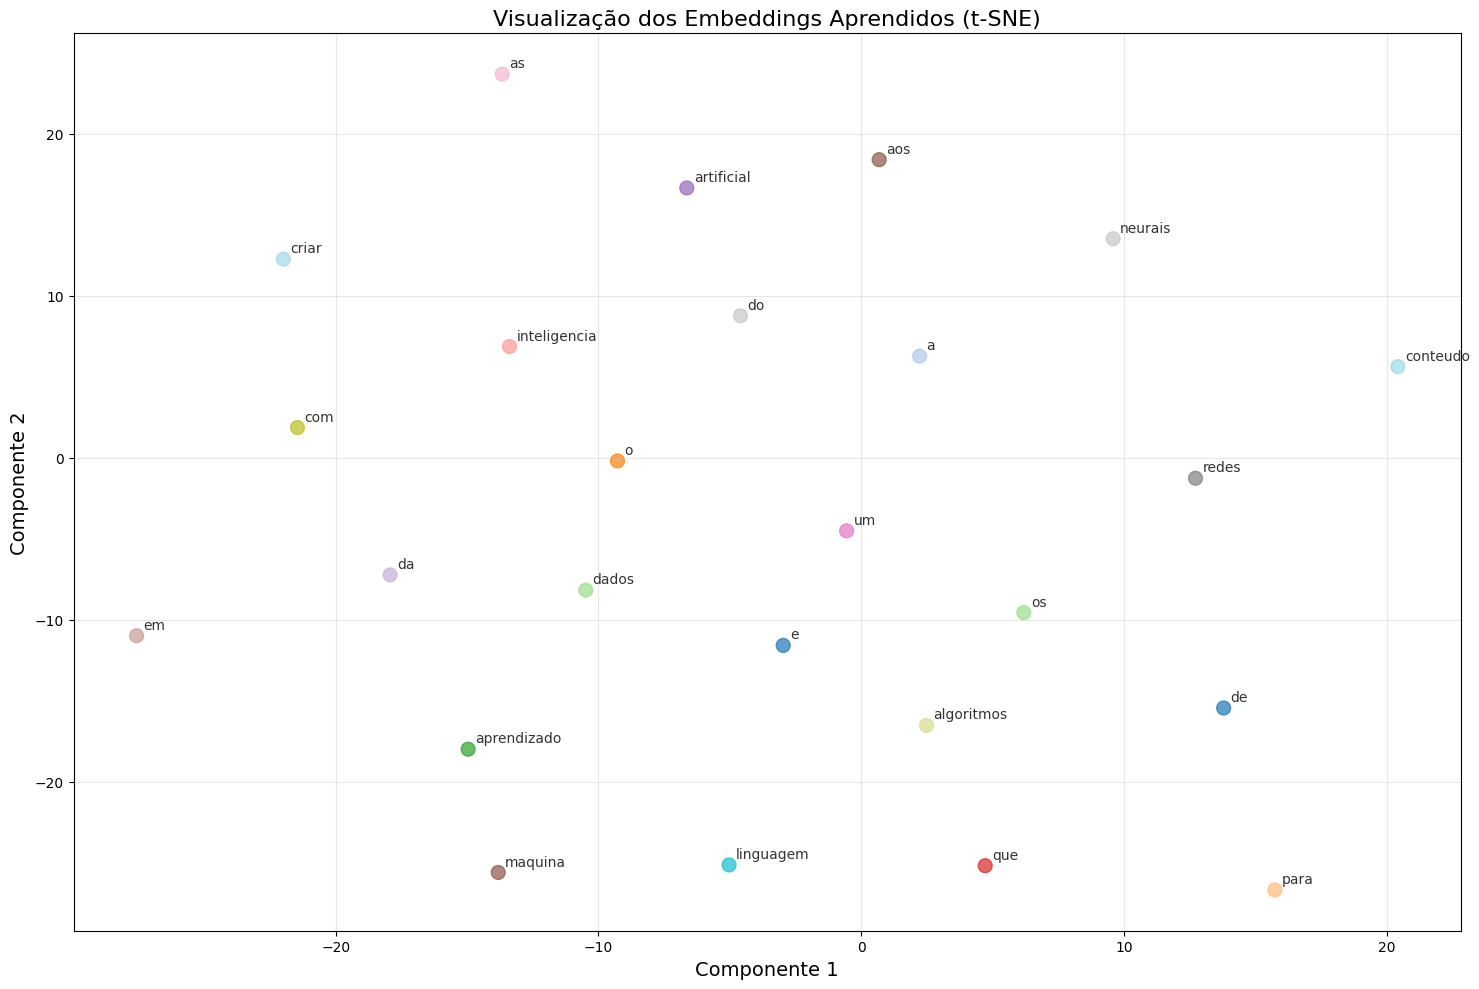

=== PALAVRAS SIMILARES ===

Palavras similares a 'inteligencia':
  descobre: 0.276
  descendente: 0.247
  uma: 0.245
  humana: 0.245
  complexas: 0.240

Palavras similares a 'aprendizado':
  maquina: 0.331
  generativos: 0.298
  forma: 0.289
  artificiais: 0.281
  computacao: 0.279

Palavras similares a 'redes':
  analisar: 0.329
  linearidade: 0.301
  linguagem: 0.271
  padroes: 0.257
  exemplos: 0.235

Palavras similares a 'dados':
  natural: 0.299
  aprendem: 0.249
  computacao: 0.236
  sobre: 0.228
  camadas: 0.219


In [14]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

def visualize_embeddings(model, vocabulary, word_to_idx, num_words=30):
    """
    Visualiza embeddings usando t-SNE.
    """
    # Extrair embeddings do modelo
    embeddings = model.embedding.weight.data.cpu().numpy()

    # Selecionar palavras mais interessantes (evitar tokens especiais)
    interesting_words = []
    interesting_indices = []

    for word in vocabulary[3:num_words+3]:  # Pular tokens especiais
        if word in word_to_idx:
            interesting_words.append(word)
            interesting_indices.append(word_to_idx[word])

    # Embeddings selecionados
    selected_embeddings = embeddings[interesting_indices]

    # Reduzir dimensionalidade com t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(15, len(interesting_words)-1))
    embeddings_2d = tsne.fit_transform(selected_embeddings)

    # Plotar
    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         alpha=0.7, s=100, c=range(len(interesting_words)),
                         cmap='tab20')

    # Adicionar labels
    for i, word in enumerate(interesting_words):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=10, alpha=0.8)

    plt.title('Visualização dos Embeddings Aprendidos (t-SNE)', fontsize=16)
    plt.xlabel('Componente 1', fontsize=14)
    plt.ylabel('Componente 2', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def find_similar_words(model, word, word_to_idx, idx_to_word, top_k=5):
    """
    Encontra palavras mais similares usando similaridade do cosseno.
    """
    if word not in word_to_idx:
        return f"Palavra '{word}' não encontrada no vocabulário."

    # Embedding da palavra alvo
    word_idx = word_to_idx[word]
    embeddings = model.embedding.weight.data.cpu().numpy()
    word_embedding = embeddings[word_idx].reshape(1, -1)

    # Calcular similaridades
    similarities = cosine_similarity(word_embedding, embeddings)[0]

    # Encontrar índices das palavras mais similares
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]  # Excluir a própria palavra

    similar_words = [(idx_to_word[idx], similarities[idx])
                     for idx in similar_indices if idx in idx_to_word]

    return similar_words

# Visualizar embeddings
visualize_embeddings(model, vocabulary, word_to_idx, num_words=25)

# Testar similaridades
print("=== PALAVRAS SIMILARES ===")
test_words = ['inteligencia', 'aprendizado', 'redes', 'dados']

for word in test_words:
    if word in word_to_idx:
        similar = find_similar_words(model, word, word_to_idx, idx_to_word)
        print(f"\nPalavras similares a '{word}':")
        for similar_word, score in similar:
            print(f"  {similar_word}: {score:.3f}")


## Exercícios

### Exercício 1: Experimentando com Hiperparâmetros

Modifique os hiperparâmetros (`embedding_dim`, `hidden_dim`, camadas, dropout...) do modelo LSTM e observe como afetam o desempenho.

Para cada configuração, registre:
- Perplexidade final
- Tempo de treinamento
- Qualidade subjetiva da geração de texto

Qual configuração oferece o melhor equilíbrio entre desempenho e eficiência?


=== Testando Configuração: {'embedding_dim': 32, 'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.2} ===


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Época [10/50], Loss: 4.4107
Época [20/50], Loss: 3.4174
Época [30/50], Loss: 2.6054
Época [40/50], Loss: 1.9223
Época [50/50], Loss: 1.3520

=== Testando Configuração: {'embedding_dim': 64, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.3} ===
Época [10/50], Loss: 3.9664
Época [20/50], Loss: 2.4877
Época [30/50], Loss: 1.5176
Época [40/50], Loss: 1.0121
Época [50/50], Loss: 0.6788

=== Testando Configuração: {'embedding_dim': 128, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.5} ===
Época [10/50], Loss: 4.0482
Época [20/50], Loss: 2.5433
Época [30/50], Loss: 1.4843
Época [40/50], Loss: 0.8622
Época [50/50], Loss: 0.5558

=== Resultados dos Experimentos ===

Configuração: {'embedding_dim': 32, 'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.2}
Perplexidade Final: 3.44
Tempo de Treinamento: 3.50 segundos
Textos Gerados:
  Temperature 0.5: inteligencia artificial criar novos o processamento para modelar e conteudo dados complexos os de sistemas maquina a de maquina para o redes neura

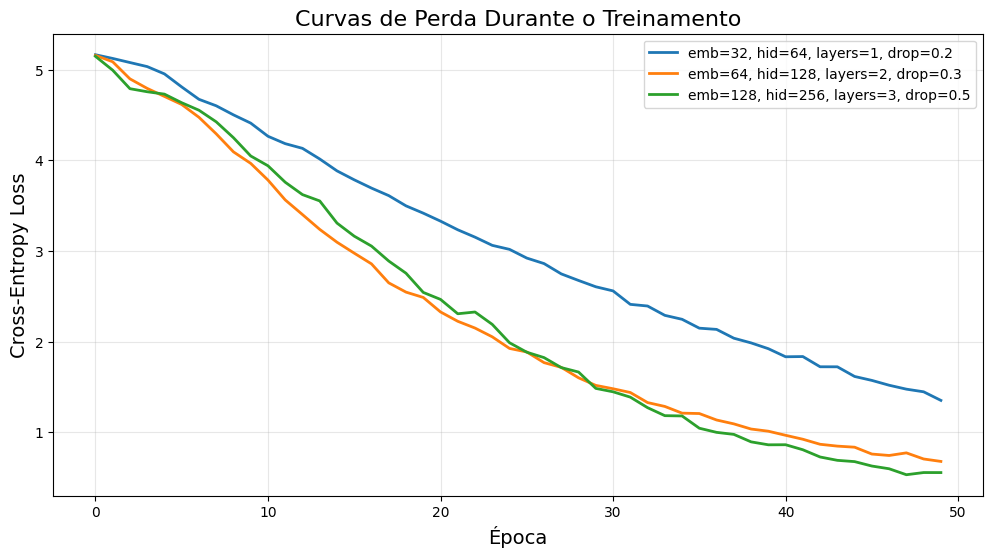

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# Configurações de hiperparâmetros para testar
configurations = [
    {'embedding_dim': 32, 'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.2},
    {'embedding_dim': 64, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.3},
    {'embedding_dim': 128, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.5},
]

# Função para treinar e avaliar uma configuração
def run_experiment(config, dataloader, vocab_size, num_epochs=50, device='cpu'):
    print(f"\n=== Testando Configuração: {config} ===")

    # Instanciar modelo
    model = LSTMLanguageModel(
        vocab_size=vocab_size,
        embedding_dim=config['embedding_dim'],
        hidden_dim=config['hidden_dim'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    ).to(device)

    # Configuração de treinamento
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Medir tempo de treinamento
    start_time = time.time()

    # Treinamento
    training_losses = []
    for epoch in range(num_epochs):
        epoch_loss = train_epoch(model, dataloader, criterion, optimizer, device)
        training_losses.append(epoch_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Época [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    training_time = time.time() - start_time

    # Calcular perplexidade
    perplexity, average_loss = calculate_perplexity(model, dataloader, device)

    # Gerar texto para avaliar qualidade subjetiva
    seed_text = "inteligencia artificial"
    generated_texts = {}
    for temp in [0.5, 1.0, 1.5]:
        text = generate_text(model, seed_text, max_length=30, temperature=temp, device=device)
        generated_texts[temp] = text

    return {
        'config': config,
        'perplexity': perplexity,
        'training_time': training_time,
        'training_losses': training_losses,
        'generated_texts': generated_texts
    }

# Executar experimentos
results = []
for config in configurations:
    result = run_experiment(config, dataloader, vocab_size=len(vocabulary), device=device)
    results.append(result)

# Exibir resultados
print("\n=== Resultados dos Experimentos ===")
for result in results:
    config = result['config']
    print(f"\nConfiguração: {config}")
    print(f"Perplexidade Final: {result['perplexity']:.2f}")
    print(f"Tempo de Treinamento: {result['training_time']:.2f} segundos")
    print("Textos Gerados:")
    for temp, text in result['generated_texts'].items():
        print(f"  Temperature {temp}: {text}")
    print("-" * 50)

# Plotar curvas de perda para todas as configurações
plt.figure(figsize=(12, 6))
for result in results:
    config = result['config']
    label = f"emb={config['embedding_dim']}, hid={config['hidden_dim']}, layers={config['num_layers']}, drop={config['dropout']}"
    plt.plot(result['training_losses'], label=label, linewidth=2)
plt.title('Curvas de Perda Durante o Treinamento', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('Cross-Entropy Loss', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

a Configuração 2 (emb=64, hid=128, layers=2, drop=0.3) oferece o melhor equilíbrio entre desempenho e eficiência, com perplexidade de 1.06, tempo de treinamento de 140.44 segundos (razoável) e textos gerados mais coerentes em comparação às Configurações 1 e 3. Essa configuração aproveita bem o corpus pequeno, evitando o custo excessivo da Configuração 3 e a baixa capacidade da Configuração 1.

### Exercício 2: Expandindo o Corpus

O corpus atual é relativamente pequeno. Sua tarefa é:

1. **Expandir o corpus**: Adicione mais texto sobre IA em português (pode usar artigos da Wikipedia, livros em domínio público, etc.)
2. **Pré-processar adequadamente**: Implemente limpeza mais robusta (remoção de URLs, normalização de acentos, etc.)
3. **Aumentar o vocabulário**: Teste com vocabulários maiores
4. **Retreinar o modelo**: Use o corpus expandido e compare os resultados

Como o tamanho do corpus afeta a qualidade da geração?

In [16]:
corpus_text = """
A inteligencia artificial e uma area da ciencia da computacao que se concentra no desenvolvimento de sistemas capazes de realizar tarefas que normalmente requerem inteligencia humana.
O aprendizado de maquina e um subcampo da inteligencia artificial que permite aos computadores aprender e melhorar automaticamente atraves da experiencia.
As redes neurais artificiais sao inspiradas no funcionamento do cerebro humano e consistem em nos interconectados que processam informacoes.
O aprendizado profundo utiliza redes neurais com multiplas camadas para modelar e compreender dados complexos.
Os algoritmos de aprendizado supervisionado aprendem a partir de exemplos rotulados para fazer predicoes sobre novos dados.
O aprendizado nao supervisionado descobre padroes ocultos em dados sem rotulos explicitos.
O processamento de linguagem natural permite que os computadores compreendam e gerem texto em linguagem humana.
A visao computacional capacita as maquinas a interpretar e analisar conteudo visual do mundo real.
Os sistemas de recomendacao utilizam algoritmos de aprendizado de maquina para sugerir produtos ou conteudo aos usuarios.
A robotica integra inteligencia artificial com engenharia mecanica para criar maquinas autonomas.
O reconhecimento de padroes e fundamental para identificar estruturas e regularidades nos dados.
Os modelos generativos podem criar novos dados que se assemelham aos dados de treinamento originais.
A otimizacao e crucial para encontrar os melhores parametros em algoritmos de aprendizado de maquina.
O overfitting ocorre quando um modelo aprende muito especificamente os dados de treino perdendo capacidade de generalizacao.
A validacao cruzada e uma tecnica para avaliar o desempenho de modelos de forma mais robusta.
As funcoes de ativacao introduzem nao linearidade nas redes neurais permitindo modelar relacoes complexas.
O gradiente descendente e um algoritmo de otimizacao usado para treinar modelos de aprendizado de maquina.
A regularizacao ajuda a prevenir o overfitting adicionando penalidades aos parametros do modelo.
Os transformadores revolucionaram o processamento de linguagem natural com mecanismos de atencao.
A inteligencia artificial generativa pode criar texto imagens audio e outros tipos de conteudo criativo.

Na informatica, a Inteligencia Artificial (IA) e genericamente a inteligencia, o raciocinio e o aprendizado exibida por maquinas semelhante ao raciocinio humano. Busca desenvolver maquinas autonomas ou sistemas especialistas capazes de simular o pensamento humano e realizar varias tarefas complexas de forma independente. E o sistema que permite aos computadores executar funcoes avancadas, como a capacidade de analisar dados em grande escala e fazer previsoes ou recomendacoes. E um campo de pesquisa em ciencia da computacao que desenvolve e estuda metodos e softwares que permitem que as maquinas percebam seu ambiente e usem o aprendizado e a inteligencia para tomar acoes que maximizem suas chances de atingir objetivos definidos. A IA iniciou na decada de 1950 com os pesquisadores Alan Turing e Herbert Simon, baseado no conceito do filosofo grego Aristoteles.

Em 1950, o matematico ingles Alan Turing escreveu sobre ser possivel uma maquina pensar e imitar o comportamento humano inteligente. Tambem esboçou uma proposta de pesquisa para tornar isto possivel. Aplicacoes de IA incluem mecanismos avancados de busca na web, como o Google Search; sistemas de recomendacao usados pelo YouTube, Amazon e Netflix; assistentes virtuais, como Google Assistant, Siri e Alexa; veiculos autonomos, como o Waymo; ferramentas generativas e criativas, como ChatGPT, DeepSeek e arte de IA; e jogo e analise sobre-humanos em jogos de estrategia, como xadrez e Go. No entanto, muitas aplicacoes de IA nao sao percebidas como IA porque ja se tornaram comuns no cotidiano das pessoas. Como por exemplo, o reconhecimento optico de caracteres (OCR) que extrai o texto de imagens; transforma conteudo nao estruturado em dados estruturados com insights prontos para negocios; traducao de textos em idiomas estrangeiros e traducao de voz.

A IA e um campo que abrange muitas disciplinas, como ciencia da computacao, estatisticas, engenharia de hardware e de software, linguistica, neurociencia e filosofia. Varios subcampos da pesquisa em IA sao centrados em objetivos especificos e no uso de ferramentas especificas. Os objetivos tradicionais da pesquisa em IA incluem raciocinio, representacao de conhecimento, planejamento, aprendizagem, processamento de linguagem natural, percepcao e suporte a robotica. A inteligencia geral — a capacidade de completar qualquer tarefa realizada por um humano em um nivel pelo menos igual — esta entre os objetivos de longo prazo do campo. Para atingir esses objetivos, os pesquisadores de IA adaptaram e integraram uma ampla gama de tecnicas, incluindo otimizacao matematica e de busca, logica formal, redes neurais artificiais e metodos baseados em estatistica, pesquisa operacional e economia. A IA tambem se baseia na psicologia, linguistica, filosofia da inteligencia artificial, neurociencia e em outros campos.

A inteligencia artificial foi fundada como disciplina academica em 1956 e o campo passou por multiplos ciclos de otimismo ao longo de sua historia, seguidos por periodos de decepcao e perda de financiamento. Os recursos e o interesse aumentaram enormemente apos 2012, quando a aprendizagem profunda superou as tecnicas de IA anteriores. Este crescimento acelerou ainda mais depois de 2017 e no inicio da decada de 2020 muitos milhares de milhoes de dólares estavam a ser investidos em IA e o campo experimentou um rapido progresso continuo no que ficou conhecido como o boom da IA. O surgimento da IA generativa avancada e sua capacidade de criar e modificar conteudo expôs diversas consequencias e danos nao intencionais no presente e levantou preocupacoes sobre os riscos da IA e seus efeitos de longo prazo no futuro, gerando discussoes sobre politicas regulatorias para garantir a seguranca e os beneficios da tecnologia.

O interesse no desenvolvimento de maquinas autonomas capazes de simular o pensamento humano e de realizar varias tarefas cresceu vertiginosamente nas ultimas decadas da segunda metade do seculo XX, realizando assim os primeiros estudos sobre inteligencia artificial (IA) a um proposito comum, a partir de iniciativas de cientistas de diversas areas, como psicologia, ciencia cognitiva, ciencia da computacao e robotica. Ferramentas eficientes em analisar problemas e oferecer solucoes e planejamentos (tomada de decisao), automatizacao de tarefas no cotidiano das pessoas.

Mas apesar dos estudos serem modernos, o conceito de inteligencia artificial nao e contemporaneo; Aristoteles (professor de Alexandre, o Grande) sonhava em substituir a mao-de-obra escrava por ferramentas autonomas, sendo esta possivelmente a primeira ideia de Inteligencia Artificial relatada, que a ciencia da computacao exploraria muito tempo depois. O desenvolvimento dessa ideia ocorreu plenamente no seculo XX, principalmente na decada de 1950, com pensadores como Alan Turing, Herbert Simon e John McCarthy. Turing escreveu o artigo "Computing Machinery and Intelligence" sobre a possibilidade de uma maquina pensar e imitar o comportamento humano inteligente com tal perfeicao, de forma que pudesse confundir ate um juiz humano. Turing tambem esboçou uma proposta de pesquisa para tornar possivel. Inicialmente os testes em IA foram repletos de sucessos – porém limitados devido o desempenho reduzido dos primeiros computadores - o que causava surpresa, foi o fato de um computador realizar atividade remotamente inteligente.

O sucesso inicial prosseguiu em 1957 com o General Problem Solver (GPS, Solucionador de problemas gerais) desenvolvido por Herbert Simon e Allen Newell, um programa foi projetado para imitar protocolos humanos de resolucao de problemas. Dentro da classe limitada de quebra-cabeças com a qual podia lidar, verificou-se que a ordem em que os seres humanos abordavam os mesmos problemas. Desse modo, o GPS talvez tenha sido o primeiro programa a incorporar a abordagem de “pensar de forma humana”.

Em 1961, a proposta de Turing voltou no artigo de Herbert Simon e Allen Newell no artigo "The Simulation of Human Thought" sobre o teste de uma teoria de resolucao humana de problemas. Esta teoria tenta explicar alguns aspectos dos processos mentais responsáveis pela inteligencia humana, um projeto de estudos conhecido pelo nome de Projeto de Simulacao Cognitiva.

Desde o inicio os fundamentos da inteligencia artificial tiveram o suporte de varias disciplinas que contribuiram com ideias, pontos de vista e tecnicas para a IA. Os filosofos (desde 400 a.C.) tornaram a IA concebivel, considerando as ideias de que a mente e, em alguns aspectos, semelhante a uma maquina, de que ela opera sobre o conhecimento codificado em alguma linguagem interna e que o pensamento pode ser usado para escolher as acoes que deverao ser executadas. Por sua vez, os matematicos forneceram as ferramentas para manipular declaracoes de certeza logica, bem como declaracoes incertas e probabilisticas. Eles tambem definiram a base para a compreensao da computacao e do raciocinio sobre algoritmos.

Os economistas formalizaram o problema de tomar decisoes que maximizam o resultado esperado para o tomador de decisoes. Os psicologos adotaram a ideia de que os seres humanos e os animais podem ser considerados maquinas de processamento de informacoes. Os linguistas mostraram que o uso da linguagem se ajusta a esse modelo. Os engenheiros de computacao fornecem os artefatos que tornam possiveis as aplicacoes de IA. Os programas de IA tendem a ser extensos e nao poderiam funcionar sem os grandes avancos em velocidade e memoria que a industria de informatica tem proporcionado.

Atualmente, a IA abrange uma enorme variedade de subcampos. Dentre esses subcampos esta o estudo de modelos conexionistas ou redes neurais. Uma rede neural pode ser vista como um modelo matematico simplificado do funcionamento do cerebro humano. Este consiste de um numero muito grande de unidades elementares de processamento, ou neuronios, que recebem e enviam estimulos ele tricos uns aos outros, formando uma rede altamente interconectada.

No processamento, sao compostos os estimulos recebidos conforme a intensidade de cada ligacao, produzindo um unico estimulo de saida. E o arranjo das interconexoes entre os neuronios e as respectivas intensidades que define as principais propriedades e o funcionamento de uma RN. O estudo das redes neurais ou o conexionismo se relaciona com a capacidade dos computadores aprenderem e reconhecerem padroes. Podemos destacar tambem o estudo da biologia molecular na tentativa de construir vida artificial e a area da robotica, ligada a biologia e procurando construir maquinas que alojem vida artificial. Outro subcampo de estudo e a ligacao da IA com a Psicologia, na tentativa de representar na maquina os mecanismos de raciocinio e de procura.

Nos ultimos anos, houve uma revolucao no trabalho em inteligencia artificial, tanto no conteudo quanto na metodologia. Agora, e mais comum usar as teorias existentes como bases, em vez de propor teorias inteiramente novas, fundamentar as informacoes em teoremas rigorosos ou na evidencia experimental rigida, em vez de utilizar como base a intuicao e destacar a relevancia de aplicacoes reais em vez de exemplos hipoteticos.

A utilizacao da IA permite obter nao somente ganhos significativos de performance, mas tambem possibilita o desenvolvimento de aplicacoes inovadoras, capazes de expandir de forma extraordinaria nossos sentidos e habilidades intelectuais. Cada vez mais presente, a inteligencia artificial simula o pensamento humano e se alastr a por nosso cotidiano. Em maio de 2017 no Brasil, foi criada a ABRIA (Associacao Brasileira de Inteligencia Artificial) com o objetivo de mapear iniciativas brasileiras no setor de inteligencia artificial, englobando os esforcos entre as empresas nacionais e formacao de mao de obra especializada. Esse passo reforca que, atualmente, a inteligencia artificial e impactante no setor economico.

A inteligencia artificial comecou como um campo experimental na decada de 1950 com pioneiros como Allen Newell e Herbert Simon, que fundaram o primeiro laboratorio de inteligencia artificial na Universidade Carnegie Mellon, e McCarthy que juntamente com Marvin Minsky, que fundaram o MIT AI Lab em 1959. Foram eles alguns dos participantes na famosa conferencia de verao de 1956 em Dartmouth College.

Historicamente, existem dois grandes estilos de investigacao em IA: IA "neats" e IA "scruffies". A IA "neats", limpa, classica ou simbolica. Envolve a manipulacao de simbolos e de conceitos abstractos, e e a metodologia utilizada na maior parte dos sistemas periciais.

Paralelamente a esta abordagem existe a abordagem IA "scruffies", ou "conexionista", da qual as redes neuronais sao o melhor exemplo. Esta abordagem cria sistemas que tentam gerar inteligencia pela aprendizagem e adaptacao em vez da criacao de sistemas desenhados com o objectivo especifico de resolver um problema. Ambas as abordagens apareceram num estagio inicial da historia de IA. Nas decadas de 1960/70 os conexionistas foram retirados do primeiro plano da investigacao em IA, mas o interesse por esta vertente da IA foi retomada na decada de 1980, quando as limitacoes da IA "limpa" comecaram a ser percebidas.

Pesquisas sobre inteligencia artificial foram intensamente custeadas na decada de 1980 pela Agencia de Projetos de Pesquisas Avancadas sobre Defesa (“Defense Advanced Research Projects Agency”), nos Estados Unidos, e pelo Projeto da Quinta Geracao (“Fifth Generation Project”), no Japao. O trabalho subsidiado fracassou no sentido de produzir resultados imediatos, a despeito das promessas grandiosas de alguns praticantes de IA, o que levou proporcionalmente a grandes cortes de verbas de agencias governamentais no final dos anos 80, e em consequencia a um arrefecimento da atividade no setor, fase conhecida como O inverno da IA. No decorrer da decada seguinte, muitos pesquisadores de IA mudaram para areas relacionadas com metas mais modestas, tais como aprendizado de maquinas, robotica e visao computacional, muito embora pesquisas sobre IA pura continuaram em niveis reduzidos.

Existem duas abordagens principais para a criacao de Sistemas de Inteligencia Artificial: O Simbolismo e o Conexionismo.

O Simbolismo ou IA Simbolica prop oe a representacao de conhecimento por meio da manipulacao de simbolos, isto e, na forma de estruturas construidas por seres humanos, normalmente baseadas em nocões de Logica. Ela teve grande impulso durante uma fase onde foram criados muitos Sistemas Especialistas, muitos deles baseados em Logica de Primeira Ordem, implementados em Prolog, ou em linguagens de programacao derivadas desta ou especializadas, como CLIPS. Normalmente programas desse tipo tem o conhecimento programado diretamente por seres humanos, o que levou a trabalhos de elicitacao de conhecimento. Apesar do sucesso inicial dos Sistemas Especialistas, a grande dificuldade de levantar e registrar conhecimento a partir de humanos e o sucesso dos processos de aprendizado de maquina a partir de dados levou a diminuicao da importância dessa vertente.

O Conexionismo ou IA Conexionista se baseia em um modelo matematico inspirado no funcionamento dos neuronios e depende do aprendizado de maquina baseado em grandes massas de dados para calibrar esse modelo, que normalmente comeca com parametros aleatorios. Essa abordagem, apesar de proposta muito cedo, nao encontrou computadores capazes de modelar problemas complexos, apesar de ter sucesso com problemas restritos de reconhecimento de padrao, o que so acontece a partir da decada de 2010, com resultados extremamente fortes no final dessa decada e no inicio da decada de 2020, a partir de modelos contendo bilhoes de parametros, como o GPT-3 e conceitos como Redes Neurais Profundas, Transformers, e Atencao.

Em torno de 2022, a maior parte da pesquisa em IA gira em torno dos conceitos de Aprendizado de Maquina e Conexionismo, havendo tambem propostas para sistemas hibridos.

Os principais pesquisadores e livros didaticos definem o campo como "o estudo e projeto de agentes inteligentes", onde um agente inteligente e um sistema que percebe seu ambiente e toma atitudes que maximizam suas chances de sucesso. Andreas Kaplan e Michael Haenlein definem a inteligencia artificial como “uma capacidade do sistema para interpretar corretamente dados externos, aprender a partir desses dados e utilizar essas aprendizagens para atingir objetivos e tarefas especificas atraves de adaptacao flexivel”. John McCarthy, quem cunhou o termo em 1956, a define como "a ciencia e engenharia de produzir sistemas inteligentes". E uma area de pesquisa da computacao dedicada a buscar metodos ou dispositivos computacionais que possuam ou multipliquem a capacidade racional do ser humano de resolver problemas, pensar ou, de forma ampla, ser inteligente. Nas ultimas

O aprendizado de maquina, tambem conhecido como aprendizado automatico, e um subcampo da engenharia e da ciencia da computacao que se desenvolveu a partir do estudo de reconhecimento de padroes e da teoria do aprendizado computacional em inteligencia artificial. Em 1959, Arthur Samuel o definiu como o campo de estudo que da aos computadores a habilidade de aprender sem serem explicitamente programados. Esse campo explora o estudo e a construcao de algoritmos que podem aprender de seus erros e fazer previsoes sobre dados. Tais algoritmos operam construindo um modelo a partir de inputs amostrais para fazer previsoes ou decisoes guiadas pelos dados, em vez de seguir instrucoes programadas in flexiveis e estaticas. Enquanto a inteligencia artificial envolve raciocinio indutivo e dedutivo, o aprendizado de maquina foca apenas no indutivo, que extrai regras e padroes de grandes conjuntos de dados.

Algumas partes do aprendizado de maquina estao intimamente ligadas a estatistica computacional, uma disciplina que foca em fazer previsoes atraves do uso de computadores, com pesquisas nas propriedades dos metodos estatisticos e sua complexidade computacional. Ele tem fortes laços com a otimizacao matematica, que produz metodos, teoria e dominios de aplicacao para este campo. O aprendizado de maquina e usado em tarefas computacionais onde programar algoritmos explicitos e impraticavel, como filtragem de spam, reconhecimento optico de caracteres, processamento de linguagem natural, motores de busca, diagnosticos medicos, bioinformatica, reconhecimento de fala, reconhecimento de escrita, visao computacional e locomocao de robos. A veces confundido com mineracao de dados, que foca em analise exploratoria e e conhecido como aprendizado nao supervisionado, o aprendizado de maquina e um metodo na analise de dados para planejar modelos complexos e algoritmos que fazem predicoes, conhecido comercialmente como analise preditiva. Esses modelos permitem que pesquisadores, cientistas de dados, engenheiros e analistas produzam decisoes confiaveis e repetiveis, descobrindo insights escondidos atraves de relacoes e tendencias historicas nos dados.

As contribuicoes para a fundacao do aprendizado de maquina feitas por John Hopfield e Geoffrey Hinton foram distinguidas em 2024 com o Premio Nobel de Fisica, destacando suas descobertas fundamentais e invençoes que permitem aprendizado automatico com redes neurais artificiais. Tom M. Mitchell forneceu uma definicao formal: um programa de computador aprende pela experiencia E, com respeito a uma tarefa T e performance P, se sua performance em T melhora com E. Essa definicao e operacional, seguindo a proposta de Alan Turing de substituir a pergunta sobre maquinas pensarem por se elas podem fazer o que entidades pensantes fazem.

As tarefas de aprendizado de maquina sao classificadas em tres categorias amplas com base no sinal ou feedback disponivel: aprendizado supervisionado, nao supervisionado e por reforco. No aprendizado supervisionado, exemplos de entradas e saidas desejadas sao apresentados ao computador por um professor, com o objetivo de aprender uma regra geral que mapeia entradas para saidas. No aprendizado nao supervisionado, nenhum tipo de etiqueta e dado ao algoritmo, que deve encontrar estrutura nas entradas sozinho, podendo ser um objetivo em si ou um meio para um fim. O aprendizado por reforco envolve um programa interagindo com um ambiente dinamico para alcancar um objetivo, recebendo feedback de premiacoes e punicoes, como dirigir um veiculo ou jogar um jogo contra um oponente.

Entre esses, existe o aprendizado semi-supervisionado, onde o sinal de treinamento e incompleto, com algumas saidas ausentes, e a transducao e um caso especial onde todo o conjunto de instancias e conhecido, mas parte dos objetivos falta. Outras categorias incluem meta-aprendizado, que aprende seu proprio viés indutivo com base em experiencias previas, e robotica epigenetica, que gera sequencias de aprendizado para robos adquirirem habilidades atraves de auto-exploracao e interacao social, usando tecnicas como aprendizado ativo, maturacao, sinergias motoras e imitacao.

Outra categorizacao considera a saida desejada: em classificacao, entradas sao divididas em classes, e o aprendiz produz um modelo para vincular entradas nao vistas a classes, tipicamente supervisionado, como na filtragem de spam. Em regressao, saidas sao continuas, tambem supervisionada. Em clustering, entradas sao divididas em grupos sem conhecimento previo, uma tarefa nao supervisionada. A estimativa de densidades encontra a distribuicao de entradas, e a reducao dimensional simplifica entradas mapeando-as para um espaco menor. A modelagem de topicos envolve encontrar documentos similares em linguagem natural.

O aprendizado de maquina cresceu da busca pela inteligencia artificial, com pesquisadores interessados em maquinas aprenderem de dados usando metodos simbolicos e redes neurais artificiais, como perceptrons, que foram reinvencoes de modelos lineares generalizados de estatistica. A logica probabilistica foi usada em diagnosticos medicos. Uma ênfase na abordagem logica baseada em conhecimento separou IA e aprendizado de maquina, com sistemas probabilisticos enfrentando problemas de aquisicao de dados. Em 1980, sistemas especialistas dominaram a IA, e estatistica ficou de lado, mas pesquisas em aprendizado baseado em conhecimento continuaram, levando a programacao logica indutiva. Redes neurais foram abandonadas pela IA, mas continuaram como conexionismo por pesquisadores como Hopfield, Rumelhart e Hinton, com sucesso na decada de 1980 via propagacao para tras.

Na decada de 1990, o aprendizado de maquina se tornou um campo separado, focando em problemas praticos, abandonando abordagens simbolicas por metodos da estatistica e probabilidade, beneficiado pela digitalizacao e internet. Ele se sobrepoe a mineracao de dados, mas enquanto aprendizado de maquina prevê baseado em dados de treinamento, mineracao descobre propriedades desconhecidas. Muitos problemas sao formulados como minimizacao de funcoes de perda, com foco na generalizacao para amostras nao vistas.

O aprendizado de maquina e a estatistica sao relacionados, com ideias do aprendizado de maquina tendo pré-historia na estatistica. Leo Breiman distinguiu modelo de dados e modelo algoritmico, como florestas aleatorias. Alguns estatisticos adotaram metodos de aprendizado de maquina no aprendizado estatistico. Um objetivo central e generalizar de experiencias, performando bem em novos exemplos. A teoria do aprendizado computacional estuda performance e complexidade, com previsoes probabilisticas comuns devido a conjuntos finitos. O trade-off entre variancia e viés qualifica o erro de generalizacao. Para melhor performance, a complexidade da hipotese deve combinar a da funcao subjacente; underfitting ocorre se menos complexa, overfitting se muito complexa.

Algoritmos especificos incluem aprendizado baseado em arvores de decisa o, que mapeia observacoes a conclusoes usando arvores de decisa o. Aprendizado por regras de associacao descobre relacoes entre variaveis em grandes bases de dados. Redes neurais artificiais sao algoritmos inspirados em redes neurais biologicas, estruturando computaçoes em neuronios artificiais interconectados para modelar relacoes complexas, encontrar padroes ou capturar estruturas estatisticas. O aprendizado profundo usa multiplas camadas escondidas em redes neurais, modelando processamento cerebral para visao computacional e reconhecimento de fala, impulsionado por hardware mais barato e GPUs.

Logica de programacao indutiva usa programacao logica para representar inputs, conhecimento e hipoteses, derivando logica que envolve exemplos positivos e nao negativos. Maquinas de vetores de suporte sao metodos supervisionados para classificacao e regressao, construindo modelos que predizem categorias de novos exemplos. Analise de clusters atribui observacoes a subconjuntos similares, uma tecnica nao supervisionada avaliada por compacidade e separacao. Redes bayesianas representam variaveis aleatorias e independencias via grafos acíclicos dirigidos, usadas para inferencia e aprendizado, como relacoes entre doencas e sintomas.

Aprendizado por reforco maximiza recompensa a longo prazo, encontrando politicas que mapeiam estados a acoes, sem pares input/output corretos. Aprendizado por representacao descobre melhores representacoes de inputs, como analise de componentes principais e clustering, preservando informacao para pré-processamento ou reconstrucao. Algoritmos de aprendizado profundo descobrem hierarquias de caracteristicas. Aprendizado por similaridade aprende funcoes de similaridade para predizer similaridades em sistemas de recomendacao. Aprendizado por dicionario esparso representa dados como combinacoes esparsas de bases, aplicado em classificacao e suavizacao de imagem. Deteccao de anomalias identifica itens raros diferentes da maioria, como fraudes ou erros. Algoritmos geneticos imitam selecao natural com mutacao e recombinacao para busca heuristica.

Aplicacoes incluem a competicao Netflix Prize em 2006, onde um modelo conjunto venceu por melhorar recomendacoes de filmes. Em 2010, Rebellion Research usou aprendizado de maquina para prever movimentos economicos. Em 2014, algoritmos estudaram pinturas de arte, revelando influencias nao reconhecidas. Em 2015, o Spotify criou a playlist Descobertas da Semana usando filtragem colaborativa, processamento de linguagem natural e redes neurais convolucionais para curadoria digital.

Modelos sao avaliados por validacao cruzada, dividindo dados em conjuntos de teste e treinamento, calculando precisao, sensibilidade, especificidade, falsos positivos e negativos. Curvas ROC e AUC medem performance, com maiores AUC indicando melhor modelo.

Redes neurais artificiais (RNAs) sao modelos computacionais inspirados pelo sistema nervoso central de um animal, em particular o cerebro, capazes de realizar aprendizado de maquina e reconhecimento de padroes. Elas sao apresentadas como sistemas de neuronios interconectados que computam valores de entradas, simulando o comportamento de redes neurais biologicas. Por exemplo, uma rede neural para reconhecimento de escrita manual e definida por neuronios de entrada ativados pelos pixels de uma imagem, cujos dados sao ponderados e transformados por uma funcao determinada pelo designer da rede, passando por outros neuronios ate ativar um neuronio de saida que identifica o caractere lido. Assim como outros metodos de aprendizado de maquina, RNAs resolvem tarefas dificeis com programacao baseada em regras, como visao computacional e reconhecimento de voz.

A inspiracao original vem do exame das estruturas do cerebro e neuronios. A propriedade mais importante das RNAs e a habilidade de interagir com o ambiente para reconhecer padroes que solucionam problemas, melhorando o desempenho por meio de um processo iterativo de ajustes nos pesos, chamado treino. A aprendizagem ocorre quando a rede atinge uma solucao generalizada para uma classe de problemas. Um algoritmo de aprendizagem e um conjunto de regras para solucionar problemas de aprendizagem. Os paradigmas de aprendizagem incluem: Aprendizagem Supervisionada, com um agente externo indicando a resposta desejada; Aprendizagem Nao Supervisionada, sem agente externo; e Aprendizagem por Reforco, com um critico externo avaliando a resposta.

RNAs sao aplicadas em reconhecimento automatico de alvos, reconhecimento de caracteres, robotica, diagnostico medico, sensoriamento remoto, processamento de voz, biometria e analise de dados, incluindo analise de imagem de sistemas quanticos. Cientistas russos usaram RNAs para substituir especialistas em caminhada quantica, treinando a maquina para reconhecer redes que indicam vantagens quanticas, auxiliando na construcao de computadores quanticos. Outras aplicacoes incluem analise de disfluencia da fala, tratamento corretivo do aparelho buco-maxilar, predicao da Doenca de Alzheimer, reconhecimento de cancer de mamas, analise do planejamento urbano de Sao Paulo, tomada de decisao em engenharia de producao e mercado financeiro.

As primeiras informacoes sobre neurocomputacao surgiram em 1943, em artigos de Warren McCulloch e Walter Pitts, que fizeram analogia entre celulas nervosas e processos eletronicos, simulando neuronios com resistores variaveis e amplificadores representando conexoes sinapticas. Na decada de 1940, John von Neumann publicou "The General and Logical Theory of Automata", influenciado pela maquina de Turing e pelo automato "Pato de Vaucanson". O livro "Cybernetics" de Norbert Wiener, de 1948, descreveu conceitos de controle e processamento de sinais, adicionando material sobre aprendizagem em 1961. Em 1949, Donald Hebb introduziu a capacidade de aprender por correlacao de neuronios, originando a Regra de Aprendizagem de Hebb.

Na decada de 1950, Marvin Minsky construiu o Snark em 1951, um neurocomputador que ajustava pesos automaticamente. O livro de W. Ross Ashby, de 1952, tratou de comportamento adaptativo aprendido. Em 1954, Dennis Gabor propôs um filtro adaptativo nao linear. Em 1956, no Dartmouth College, surgiram os paradigmas da Inteligencia Artificial simbolica e conexionista. Frank Rosenblatt iniciou testes com o Perceptron em 1957 e o criou em 1958, um modelo com unidades sensoriais conectadas a uma camada de neuronios de McCulloch e Pitts, capaz de aprender padroes linearmente separaveis.

Na decada de 1960, Bernard Widrow e Ted Hoff publicaram o ADALINE em 1960, baseado no modelo de McCulloch e Pitts, com a regra Delta. Em 1969, o livro "Perceptrons" de Minsky e Papert expôs limitacoes do modelo de Rosenblatt, reduzindo o interesse em RNAs. Na decada de 1970, poucos progressos ocorreram devido a previsoes exageradas, mas pesquisadores como Igor Aleksander, Kunihiko Fukushima, Steven Grossberg e Teuvo Kohonen continuaram, desenvolvendo modelos como cognitron, neocognitron e memorias associativas. Em 1974, Paul Werbos lancou bases para o algoritmo de retropropagacao.

Na decada de 1980, com avancos tecnologicos e o fracasso da escola simbolista, as RNAs atraíram atencao novamente. O artigo de John Hopfield em 1982 destacou propriedades associativas, relacionando redes recorrentes a sistemas fisicos. Teuvo Kohonen publicou sobre redes auto-organizadas. Geoffrey Hinton e Terence Sejnowski estenderam o modelo de Hopfield com dinamica estocastica, criando a Maquina de Boltzmann. Em 1986, Rumelhart, Hinton e Williams descreveram o algoritmo backpropagation, essencial para ajustar pesos. O livro "Parallel Distributed Processing" de 1986 impulsionou o desenvolvimento, levando a conferencias e sociedades como a IEEE International Conference on Neural Networks e a International Neural Networks Society.

RNAs tem vantagens por se basearem no sistema nervoso humano. Sua aprendizagem ocorre em uma fase de fornecimento de dados de entrada e saida esperada. Elas se auto-organizam, criando representacoes internas de informacao, tem tolerancia a falhas por armazenamento redundante, flexibilidade para lidar com mudancas na entrada, como ruido ou variacoes em imagens, e operam em tempo real devido a estrutura paralela. Os neuronios sao dispostos em camadas, com arquitetura definida pela disposicao e conexoes. Redes sem realimentacao (feedforward) tem sinal unidirecional, sem conexoes na mesma camada. Redes com realimentacao (recorrentes) tem saidas que alimentam camadas anteriores, com memoria dinamica para sistemas dinamicos, como a rede de Hopfield.

Uma rede feedforward tipica tem nos de entrada, saida e camadas escondidas, com pesos numericos em conexoes. Durante operacao, valores de entrada sao multiplicados pelos pesos, somados e processados por funcoes como sigmoide, que introduz nao-linearidade comprimindo ativacoes para [0,1]. Outras funcoes incluem tanh para [-1,1]. Sem nao-linearidade, a rede se reduz a algebra linear simples. Pesos iniciais sao aleatorios, ajustados durante treinamento para convergir a computacoes uteis, representando aquisicao de conhecimento sub-simbolico. Sao uteis para dados de valor real, realizando classificacao por graus e expressando incerteza, especialmente com funcao de erro de entropia cruzada e saidas sigmoides como probabilidades posteriores.

O aprendizado modifica pesos iterativamente por paradigmas: Supervisionado, com pares entrada-saida; por Reforco, com indicacoes de adequacao; Nao-supervisionado, sem pares ou indicacoes. RNAs simulam o cerebro humano, aprendendo, errando e descobrindo, com nos de processamento simulando neuronios que somam entradas e geram saidas se acima de um limiar. Podem ter multiplas camadas: entrada para padroes, intermediaria para processamento e saida para resultados. Mais camadas aumentam capacidade de aprendizado. A camada de entrada inclui bias para maior adaptacao. O numero de camadas define representacao de relacoes; sem intermediaria, como no Perceptron, limita a relacoes lineares; com intermediarias, como no Perceptron Multicamadas, representa funcoes continuas ou nao.

RNAs processam diferentes tipos de informacoes: analogicas, com valores continuos (ex.: Hopfield, Kohonen); discretas, com valores booleanos (ex.: Maquina de Boltzmann). Sao diferentes do cerebro em estrutura e escala, mas compartilham paralelismo e interligacoes como base de inteligencia. Em redes pro-alimentadas, nos de entrada recebem valores, multiplicados por pesos, somados e processados por sigmoide ate saida. Ponderadores iniciais aleatorios convergem com treinamento. Uteis para aproximacao de funcoes, previsao de series temporais, classificacoes e reconhecimento de padroes. Redes recorrentes com algoritmos geneticos produzem controladores roboticos.

Tipos incluem Perceptron de uma camada, que aprende problemas linearmente separaveis com regra-delta, mas nao XOR. Perceptron Multicamadas usa propagacao reversa para aproximar qualquer funcao continua com uma camada oculta. Redes RBF agrupam dados por hiperelipsoides, transformando padroes nao-lineares em lineares. Redes ART categorizam padroes binarios ou analogicos sem treinamento previo, com aprendizado rapido ou lento em fases de reconhecimento, comparacao e busca, aplicadas em reconhecimento de alvos e diagnostico medico. A Rede de Hopfield e uma memoria auto-associativa binaria assincrona para restaurar padroes corrompidos, minimizando energia, aplicada em identificacao de alvos, autenticacao e predicao financeira.

Memoria associativa armazena e recupera por associacao, util para padroes ruidosos, como reconhecimento facial. Modelos morfologicos usam operacoes reticulares em vez de multiplicacao de matrizes. RNAs tem capacidade computacional como aproximadores universais e poder de Maquina de Turing em arquiteturas recorrentes. Convergencia depende de fatores como minimos locais e metodos de otimizacao. Generalizacao evita excesso de treinamento por validacao cruzada ou regularizacao, com analise estatistica para confianca. Na neurociencia computacional, modelam sistemas biologicos ligando dados observados a mecanismos plausiveis e teoria.
"""

Original - Época [10/30], Loss: 3.9854
Original - Época [20/30], Loss: 2.4674
Original - Época [30/30], Loss: 1.5606
Original - Perplexidade: 3.66, Tempo: 6.70s, Sequências: 306, Vocab: 174
Expandido - Época [10/30], Loss: 3.6389
Expandido - Época [20/30], Loss: 2.5578
Expandido - Época [30/30], Loss: 1.6604
Expandido - Perplexidade: 3.29, Tempo: 113.74s, Sequências: 5126, Vocab: 500


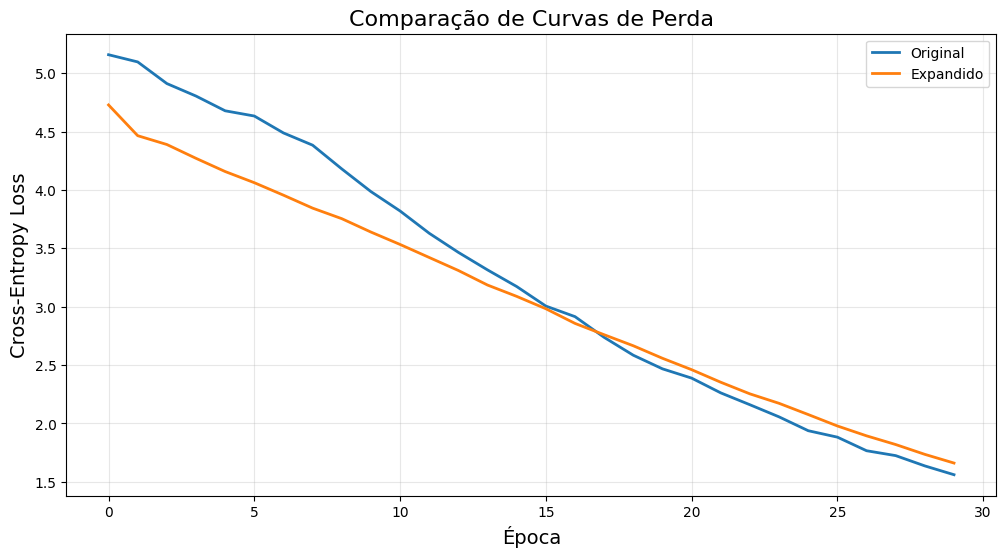


=== GERAÇÃO DE TEXTO (Temperature=1.0) ===
Original: inteligencia artificial parametros do dados dados em e fazer que de nao o generativa sem visao os atraves um o computadores do
Expandido: inteligencia artificial as padroes conteudo complexos as do crucial de para para da sistemas e a


In [17]:
import re
import unicodedata
from collections import Counter
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# Função de pré-processamento
def preprocess_text(text):
    """Limpa e tokeniza o texto com normalização de acentos e remoção de URLs."""
    # Remover URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'www\.[a-zA-Z0-9-]+\.[a-zA-Z]{2,}', '', text)

    # Converter para minúsculas
    text = text.lower()

    # Normalizar acentos
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

    # Remover caracteres especiais, manter letras e espaços
    text = re.sub(r'[^a-záàâãéèêíìîóòôõúùûç\s]', '', text)

    # Tokenizar por palavras
    tokens = text.split()

    return tokens

# Construir vocabulário (função original, mas com vocab_size maior)
def build_vocabulary(tokens, vocab_size=500):  # Aumentado para 500
    counter = Counter(tokens)
    special_tokens = ['<UNK>', '<START>', '<END>']
    frequent_words = [word for word, _ in counter.most_common(vocab_size - len(special_tokens))]
    vocabulary = special_tokens + frequent_words
    word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return vocabulary, word_to_idx, idx_to_word

# === CORPUS ORIGINAL ===
corpus_text_original = """
A inteligencia artificial e uma area da ciencia da computacao que se concentra no desenvolvimento de sistemas capazes de realizar tarefas que normalmente requerem inteligencia humana.
O aprendizado de maquina e um subcampo da inteligencia artificial que permite aos computadores aprender e melhorar automaticamente atraves da experiencia.
As redes neurais artificiais sao inspiradas no funcionamento do cerebro humano e consistem em nos interconectados que processam informacoes.
O aprendizado profundo utiliza redes neurais com multiplas camadas para modelar e compreender dados complexos.
Os algoritmos de aprendizado supervisionado aprendem a partir de exemplos rotulados para fazer predicoes sobre novos dados.
O aprendizado nao supervisionado descobre padroes ocultos em dados sem rotulos explicitos.
O processamento de linguagem natural permite que os computadores compreendam e gerem texto em linguagem humana.
A visao computacional capacita as maquinas a interpretar e analisar conteudo visual do mundo real.
Os sistemas de recomendacao utilizam algoritmos de aprendizado de maquina para sugerir produtos ou conteudo aos usuarios.
A robotica integra inteligencia artificial com engenharia mecanica para criar maquinas autonomas.
O reconhecimento de padroes e fundamental para identificar estruturas e regularidades nos dados.
Os modelos generativos podem criar novos dados que se assemelham aos dados de treinamento originais.
A otimizacao e crucial para encontrar os melhores parametros em algoritmos de aprendizado de maquina.
O overfitting ocorre quando um modelo aprende muito especificamente os dados de treino perdendo capacidade de generalizacao.
A validacao cruzada e uma tecnica para avaliar o desempenho de modelos de forma mais robusta.
As funcoes de ativacao introduzem nao linearidade nas redes neurais permitindo modelar relacoes complexas.
O gradiente descendente e um algoritmo de otimizacao usado para treinar modelos de aprendizado de maquina.
A regularizacao ajuda a prevenir o overfitting adicionando penalidades aos parametros do modelo.
Os transformadores revolucionaram o processamento de linguagem natural com mecanismos de atencao.
A inteligencia artificial generativa pode criar texto imagens audio e outros tipos de conteudo criativo.
"""
tokens_original = preprocess_text(corpus_text_original)
vocabulary_original, word_to_idx_original, idx_to_word_original = build_vocabulary(tokens_original, vocab_size=200)
encoded_tokens_original = encode_tokens(tokens_original, word_to_idx_original)
seq_length = 10
sequences_original, targets_original = create_training_sequences(encoded_tokens_original, seq_length)
dataset_original = LanguageModelDataset(sequences_original, targets_original)
dataloader_original = DataLoader(dataset_original, batch_size=32, shuffle=True)

# Treinar modelo original
model_original = LSTMLanguageModel(len(vocabulary_original), 64, 128, 2, 0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_original = optim.Adam(model_original.parameters(), lr=0.001)
start_time_original = time.time()
training_losses_original = []
num_epochs = 30
for epoch in range(num_epochs):
    epoch_loss = train_epoch(model_original, dataloader_original, criterion, optimizer_original, device)
    training_losses_original.append(epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Original - Época [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
time_original = time.time() - start_time_original
perplexity_original, _ = calculate_perplexity(model_original, dataloader_original, device)
print(f"Original - Perplexidade: {perplexity_original:.2f}, Tempo: {time_original:.2f}s, Sequências: {len(sequences_original)}, Vocab: {len(vocabulary_original)}")

# === CORPUS EXPANDIDO ===
tokens_expanded = preprocess_text(corpus_text)
vocabulary_expanded, word_to_idx_expanded, idx_to_word_expanded = build_vocabulary(tokens_expanded, vocab_size=500)
encoded_tokens_expanded = encode_tokens(tokens_expanded, word_to_idx_expanded)
sequences_expanded, targets_expanded = create_training_sequences(encoded_tokens_expanded, seq_length)
dataset_expanded = LanguageModelDataset(sequences_expanded, targets_expanded)
dataloader_expanded = DataLoader(dataset_expanded, batch_size=32, shuffle=True)

# Treinar modelo expandido
model_expanded = LSTMLanguageModel(len(vocabulary_expanded), 64, 128, 2, 0.3).to(device)
optimizer_expanded = optim.Adam(model_expanded.parameters(), lr=0.001)
start_time_expanded = time.time()
training_losses_expanded = []
for epoch in range(num_epochs):
    epoch_loss = train_epoch(model_expanded, dataloader_expanded, criterion, optimizer_expanded, device)
    training_losses_expanded.append(epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Expandido - Época [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
time_expanded = time.time() - start_time_expanded
perplexity_expanded, _ = calculate_perplexity(model_expanded, dataloader_expanded, device)
print(f"Expandido - Perplexidade: {perplexity_expanded:.2f}, Tempo: {time_expanded:.2f}s, Sequências: {len(sequences_expanded)}, Vocab: {len(vocabulary_expanded)}")

# Comparar curvas de perda
plt.figure(figsize=(12, 6))
plt.plot(training_losses_original, label='Original', linewidth=2)
plt.plot(training_losses_expanded, label='Expandido', linewidth=2)
plt.title('Comparação de Curvas de Perda', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('Cross-Entropy Loss', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Geração de texto para comparação
seed = "inteligencia artificial"
print("\n=== GERAÇÃO DE TEXTO (Temperature=1.0) ===")
print("Original:", generate_text(model_original, seed, max_length=20, temperature=1.0, device=device))
print("Expandido:", generate_text(model_expanded, seed, max_length=20, temperature=1.0, device=device))

### Exercício 3: Implementando Top-k e Nucleus Sampling

A função `generate_text` atual usa apenas temperature sampling. Implemente duas estratégias mais avançadas:

1. **Top-k Sampling**: Considere apenas as k palavras mais prováveis
2. **Top-p Sampling**: Considere o menor conjunto de palavras cuja probabilidade acumulada seja ≥ p

Compare a qualidade da geração entre as diferentes estratégias.

In [18]:
import torch
import torch.nn.functional as F

def generate_text(model, seed_text, max_length=50, temperature=1.0, top_k=None, top_p=None, device='cpu'):
    model.eval()
    seed_tokens = preprocess_text(seed_text)
    if len(seed_tokens) == 0:
        seed_tokens = ['inteligencia']
    seed_indices = encode_tokens(seed_tokens, word_to_idx)
    if len(seed_indices) < seq_length:
        start_idx = word_to_idx.get('<START>', word_to_idx['<UNK>'])
        seed_indices = [start_idx] * (seq_length - len(seed_indices)) + seed_indices
    else:
        seed_indices = seed_indices[-seq_length:]
    generated_indices = seed_indices.copy()
    current_sequence = seed_indices.copy()
    with torch.no_grad():
        for _ in range(max_length):
            input_tensor = torch.LongTensor([current_sequence]).to(device)
            output, _ = model(input_tensor)
            last_logits = output[0, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / temperature
            probabilities = F.softmax(last_logits, dim=0)
            if top_k is not None:
                top_k_probs, top_k_indices = torch.topk(probabilities, top_k)
                probabilities = torch.zeros_like(probabilities)
                probabilities.scatter_(0, top_k_indices, top_k_probs)
                probabilities = probabilities / probabilities.sum() if probabilities.sum() > 0 else probabilities
            elif top_p is not None:
                sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)
                cumulative_probs = torch.cumsum(sorted_probs, dim=0)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                probabilities[indices_to_remove] = 0
                probabilities = probabilities / probabilities.sum() if probabilities.sum() > 0 else probabilities
            next_token_idx = torch.multinomial(probabilities, 1).item()
            if next_token_idx == word_to_idx.get('<END>', -1):
                break
            generated_indices.append(next_token_idx)
            current_sequence = current_sequence[1:] + [next_token_idx]
    generated_words = [idx_to_word.get(idx, '<UNK>') for idx in generated_indices if idx_to_word.get(idx) not in ['<START>', '<END>', '<UNK>']]
    return ' '.join(generated_words)

seed = "inteligencia artificial"
print("Temperature Sampling (temp=1.0):", generate_text(model_expanded, seed, temperature=1.0, device=device))
print("Top-k Sampling (k=50):", generate_text(model_expanded, seed, top_k=50, device=device))
print("Top-p Sampling (p=0.9):", generate_text(model_expanded, seed, top_p=0.9, device=device))

Temperature Sampling (temp=1.0): inteligencia artificial <UNK> <UNK> sem a as usado da modelar um otimizacao de identificar de modelos analisar em computadores de artificial de artificial de redes penalidades predicoes <UNK> <UNK> aprende <UNK> regularizacao as neurais de humana de <UNK> novos as <UNK>
Top-k Sampling (k=50): inteligencia artificial <UNK> forma as humano dados do nos <UNK> e maquina autonomas overfitting modelo a subcampo algoritmos aprendizado um <UNK> <UNK> o validacao de aos usuarios <UNK> de da aprendizado <UNK> <UNK> algoritmos ciencia inteligencia regularidades ciencia inteligencia multiplas e tipos inspiradas introduzem de texto os da <UNK>
Top-p Sampling (p=0.9): inteligencia artificial automaticamente usuarios <UNK> transformadores o conteudo para overfitting inspiradas capacidade utilizam dados overfitting permite <UNK> para <UNK> de aprender inteligencia aos <UNK> um aos sistemas a aos aprendem a sobre de <UNK> algoritmos do sem um aprendizado um nos o <UNK> 